- nom : OUCHERIF
- prénom : Rima 
- L3 informatique 
- adresse mail : rima.oucherif@universite-paris-saclay.fr

#  1. Introduction

Les jeux de données médicaux peuvent contenir des déséquilibres susceptibles d’introduire des biais dans les analyses réalisées. Ces biais ne proviennent pas uniquement des modèles d’apprentissage automatique, mais peuvent être présents dès la structure même des données.

Dans ce projet, nous analysons un jeu de données issu de radiographies thoraciques comprenant des informations sur l'âge, le genre et des annotations médicales. L’objectif est d’identifier les biais potentiels présents dans le dataset avant toute modélisation.

L’étude se concentre sur trois dimensions : le déséquilibre lié au genre, la distribution des tranches d’âge et l’hétérogénéité des pathologies. Afin de réduire l’impact de ces déséquilibres, différentes méthodes de mitigation par pré-traitement sont ensuite explorées, notamment la pondération inversement proportionnelle à la fréquence des groupes ainsi que le rééchantillonnage du jeu de données.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Préparation de la donnée

## Chargement du dataset

In [2]:
df = pd.read_csv("Oucherif_Rima.csv")
df.head(6)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
1,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
2,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
3,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168
4,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143
5,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168


## Dimensions et structure du dataset

In [3]:
df.shape

(54819, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54819 entries, 0 to 54818
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  54819 non-null  object 
 1   Finding Labels               54819 non-null  object 
 2   Follow-up #                  54819 non-null  int64  
 3   Patient ID                   54819 non-null  int64  
 4   Patient Age                  54819 non-null  int64  
 5   Patient Gender               54819 non-null  object 
 6   View Position                54819 non-null  object 
 7   OriginalImage[Width          54819 non-null  int64  
 8   Height]                      54819 non-null  int64  
 9   OriginalImagePixelSpacing[x  54819 non-null  float64
 10  y]                           54819 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 4.6+ MB


## Vérification des valeurs manquantes

In [5]:
df.isnull().sum()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
dtype: int64

La vérification des valeurs manquantes montre qu’aucune des variables du jeu de données ne contient de valeurs nulles. Il n’est donc pas nécessaire d’appliquer des méthodes d’imputation lors de la préparation des données.

## le problème des patients multiples

Dans le dataset : un même patient peut apparaître plusieurs fois, donc certaines observations ne sont pas indépendantes. On va pas modifiée cette structure, mais cela doit être gardée à l’esprit lors de l’interprétation des résultats.

In [6]:
df.shape[0]
df["Patient ID"].nunique() #unique < nombre de lignes, donc certains patients apparaissent plusieurs fois

15000

## Gestion des valeurs aberrantes – Âge

In [7]:
df["Patient Age"].describe()

count    54819.000000
mean        46.981156
std         16.764159
min          1.000000
25%         35.000000
50%         49.000000
75%         59.000000
max        412.000000
Name: Patient Age, dtype: float64

### Détection des valeurs aberrantes

In [8]:
df[df["Patient Age"] < 0]
df[df["Patient Age"] > 120]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
9856,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139
23501,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143
28809,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143
36842,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143
38641,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143
41624,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139
44853,00022811_000.png,No Finding,0,22811,412,M,PA,3056,2544,0.139,0.139


### suppression des valeurs aberrantes

In [9]:
df = df[(df["Patient Age"] >= 0) & (df["Patient Age"] <= 120)]
df.iloc[41624]

Image Index                      00021047_008.png
Finding Labels                 Pleural_Thickening
Follow-up #                                     8
Patient ID                                  21047
Patient Age                                    52
Patient Gender                                  M
View Position                                  PA
OriginalImage[Width                          2674
Height]                                      2750
OriginalImagePixelSpacing[x                 0.143
y]                                          0.143
Name: 41630, dtype: object

Les âges négatifs ou supérieurs à 120 ans sont considérés comme aberrants, donc on les supprime du jeu de données afin de garantir la cohérence des analyses.

## Sélection et transformation des colonnes

In [10]:
cols_utiles = [  #on conserve seulement les variables pertinante pour l'analyse des biais 
    "Patient Age",
    "Patient Gender",
    "Finding Labels"
]

df = df[cols_utiles]
df.head()

,Patient Age,Patient Gender,Finding Labels
0,81,M,No Finding
1,81,F,Hernia
2,74,F,Hernia
3,75,F,Hernia
4,76,F,Hernia|Infiltration


less variables telles de l’identifiant du patient (Patient ID), l’identifiant de l’image (Image Index), le numéro de suivi (Follow-up #) ainsi que les caractéristiques techniques des images ont été exclues de l’analyse. Ces variables ne portent pas d’information médicale pertinente pour l’étude des biais et donc elles pourraient introduire des biais artificiels ou des fuites d’information si elles étaient utilisées.

## Harmonisation des valeurs catégorielles
### Vérification du genre

In [11]:
df["Patient Gender"].value_counts()  #on verfie qu'il ya que deux valeur possible M et F

Patient Gender
M    30812
F    24000
Name: count, dtype: int64

À l’issue de cette étape, le jeu de données est nettoyé, cohérent et réduit aux variables nécessaires pour l’analyse des biais. Il est désormais prêt pour une analyse descriptive approfondie et l’observation des éventuels déséquilibres entre groupes.

# 3. Analyse descriptive et observation des bias
## I. Biais liés au genre
### Répartition de l’attribut sensible (Patient Gender)

In [12]:
df["Patient Gender"].value_counts() #compter le nombre de patients par genre

Patient Gender
M    30812
F    24000
Name: count, dtype: int64

In [13]:
df["Patient Gender"].value_counts(normalize=True) #meme chose en pourcentage

Patient Gender
M    0.56214
F    0.43786
Name: proportion, dtype: float64

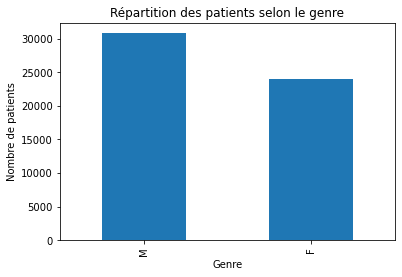

In [14]:
df["Patient Gender"].value_counts().plot(kind="bar")
plt.title("Répartition des patients selon le genre")
plt.xlabel("Genre")
plt.ylabel("Nombre de patients")
plt.show()

La répartition des patients selon le genre montre un déséquilibre entre les deux groupes. Les patients de genre masculin sont plus nombreux que les patients de genre féminin. Ce déséquilibre constitue une première source de biais potentiel, car un modèle entraîné sur ces données pourrait être davantage optimisé pour le groupe majoritaire en l'occurence ici le groupe majoritaire est le genre masculin.

### distribution de l’âge selon le genre

In [15]:
#On verifie si les deux groupes ont le meme profil d’age
df.groupby("Patient Gender")["Patient Age"].describe() 

,count,mean,std,min,25%,50%,75%,max
Patient Gender,,,,,,,,
F,24000.0,46.431375,16.219628,1.0,35.0,48.0,58.0,95.0
M,30812.0,47.360444,16.744029,1.0,34.0,50.0,60.0,94.0


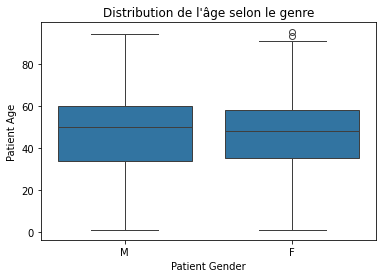

In [16]:
sns.boxplot(
    data=df,
    x="Patient Gender",
    y="Patient Age"
)
plt.title("Distribution de l'âge selon le genre")
plt.show()

L’analyse de la distribution de l’âge selon le genre montre que les patients masculins sont en moyenne légèrement plus âgés que les patientes féminines (47,4 ans contre 46,4 ans). La médiane est également plus élevée chez les hommes (50 ans contre 48 ans), tandis que la dispersion des âges reste comparable entre les deux groupes.

### Observation des labels médicaux selon le genre

In [18]:
#on regarde si certaine pathologies sont plus fréquentes dans un groupe
df.groupby("Patient Gender")["Finding Labels"].value_counts(normalize=True)

Patient Gender  Finding Labels                     
F               No Finding                             0.541167
                Infiltration                           0.085958
                Effusion                               0.036708
                Atelectasis                            0.033292
                Pneumothorax                           0.024167
                                                         ...   
M               Nodule|Effusion                        0.000032
                Nodule|Pleural_Thickening|Pneumonia    0.000032
                Nodule|Pneumonia|Mass                  0.000032
                Pneumothorax|Atelectasis               0.000032
                Pneumothorax|Infiltration              0.000032
Name: proportion, Length: 928, dtype: float64

L’analyse des proportions des labels médicaux selon le genre met en évidence des différences significatives de distribution entre les patients masculins et féminins. En particulier, la proportion de patients ne présentant aucune pathologie (No Finding) est plus élevée chez les femmes (environ 54 %), tandis que certaines pathologies apparaissent avec des fréquences différentes selon le genre.

## II. Biais liés à l’âge

In [19]:
df["Patient Age"].describe()

count    54812.000000
mean        46.953642
std         16.522745
min          1.000000
25%         35.000000
50%         49.000000
75%         59.000000
max         95.000000
Name: Patient Age, dtype: float64

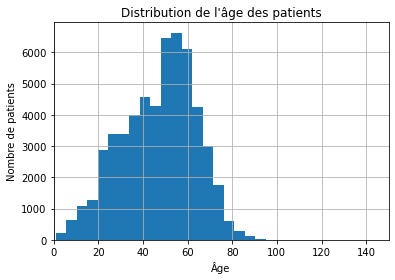

In [20]:
df["Patient Age"].hist(bins=20)
plt.title("Distribution de l'âge des patients")
plt.xlabel("Âge")
plt.ylabel("Nombre de patients")
plt.xlim(0, 150)
plt.show()


L’histogramme montre une concentration importante des observations entre environ 30 et 65 ans, avec un pic autour de la cinquantaine. Les patients très jeunes et très âgés sont nettement moins représentés dans le jeu de données.

Cette distribution non uniforme indique un déséquilibre entre les différentes tranches d’âge : les analyses sont principalement influencées par les patients d’âge moyen, tandis que les extrêmes sont sous-représentés. Ce déséquilibre constitue une source de biais potentiel, car les résultats obtenus peuvent ne pas être également représentatifs pour l’ensemble des groupes d’âge. Étant donné que l’âge est fortement lié à la présence et au type de pathologies, ce biais peut également induire des effets indirects dans l’étude des données médicales.

## III.Biais liés à la distribution des maladies

### Les maladies les plus fréquentes :

In [21]:
df["Finding Labels"].value_counts().head(10)

Finding Labels
No Finding                  29284
Infiltration                 4684
Atelectasis                  2067
Effusion                     1970
Nodule                       1325
Mass                         1097
Pneumothorax                 1033
Effusion|Infiltration         820
Consolidation                 664
Atelectasis|Infiltration      642
Name: count, dtype: int64

### Les maladies les plus rares : 

In [22]:
df["Finding Labels"].value_counts().tail(10)

Finding Labels
Cardiomegaly|Effusion|Fibrosis|Infiltration                          1
Atelectasis|Consolidation|Effusion|Infiltration|Mass|Pneumothorax    1
Atelectasis|Fibrosis|Infiltration|Nodule|Pneumothorax                1
Consolidation|Mass|Pneumonia|Pneumothorax                            1
Consolidation|Emphysema|Mass|Pneumothorax                            1
Edema|Infiltration|Mass|Nodule|Pneumonia                             1
Consolidation|Fibrosis|Mass|Pleural_Thickening                       1
Consolidation|Effusion|Infiltration|Mass|Pneumothorax                1
Atelectasis|Consolidation|Effusion|Nodule|Pneumothorax               1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax       1
Name: count, dtype: int64

L’analyse met en évidence un fort déséquilibre entre les différentes pathologies présentes dans le jeu de données. Une part importante des observations correspond à l’absence de pathologie (No Finding), qui représente à elle seule plus de la moitié des données. De plus, quelques pathologies comme Infiltration, Atelectasis ou Effusion sont largement sur-représentées par rapport aux autres.

À l’inverse, un grand nombre de pathologies ou de combinaisons de pathologies apparaissent de manière extrêmement rare, parfois une seule fois dans l’ensemble du jeu de données. Cette forte hétérogénéité révèle un biais de représentation des maladies : les analyses sont principalement influencées par les situations médicales les plus fréquentes, tandis que les cas rares sont peu représentés. Ce déséquilibre peut limiter la capacité des analyses à être équitables et généralisables à l’ensemble des pathologies.

# 4. Méthode de mitigation des biais par pré-processing


## I. Mitigation des biais liés au genre

on va faire du Reweighting

### Avant pondération

In [23]:
gender_counts = df["Patient Gender"].value_counts()
gender_distribution = df["Patient Gender"].value_counts(normalize=True)
gender_distribution

Patient Gender
M    0.56214
F    0.43786
Name: proportion, dtype: float64

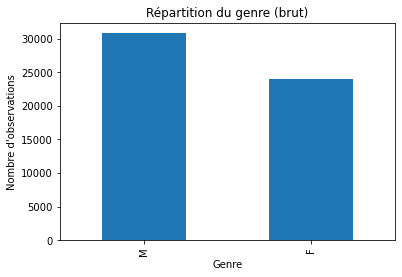

In [24]:
gender_counts.plot(kind="bar")
plt.title("Répartition du genre (brut)")
plt.xlabel("Genre")
plt.ylabel("Nombre d'observations")
plt.show()

### calcul des poids

In [25]:
df["weight"] = df["Patient Gender"].apply(lambda g: 1 / gender_distribution[g])

print("Aperçu des poids :")
display(df[["Patient Gender", "weight"]].head(10))

print("Poids moyen par genre :")
display(df.groupby("Patient Gender")["weight"].mean())


Aperçu des poids :


,Patient Gender,weight
0,M,1.778917
1,F,2.283833
2,F,2.283833
3,F,2.283833
4,F,2.283833
5,F,2.283833
6,F,2.283833
7,F,2.283833
8,F,2.283833
9,F,2.283833


Poids moyen par genre :


Patient Gender
F    2.283833
M    1.778917
Name: weight, dtype: float64

Les femmes (groupe minoritaire) ont un poids plus élevé

Les hommes (groupe majoritaire) ont un poids plus faible

On compense le déséquilibre sans supprimer de données.

### Aprés pondération

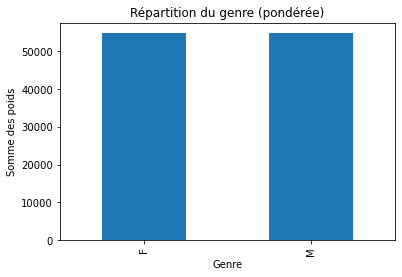

In [26]:
weighted_gender = df.groupby("Patient Gender", observed=True)["weight"].sum()

weighted_gender.plot(kind="bar")
plt.title("Répartition du genre (pondérée)")
plt.xlabel("Genre")
plt.ylabel("Somme des poids")
plt.show()

Le calcul du poids moyen par genre montre que les patientes ont un poids moyen plus élevé que les patients masculins (2,28 contre 1,78), ce qui reflète le déséquilibre initial du jeu de données, les femmes étant sous-représentées.

L’application d’une pondération inversement proportionnelle à la fréquence du genre permet de renforcer l’influence statistique du groupe minoritaire et d’atténuer celle du groupe majoritaire. Après pondération, la somme des poids par genre devient comparable, ce qui signifie que les deux groupes contribuent de manière plus équilibrée aux analyses.

## II. Extension possible : mitigation des biais liés à l’âge et aux pathologies

on va faire du Reweighting

## II.a mitigation des biais liés à l’âge

### Avant pondération : 

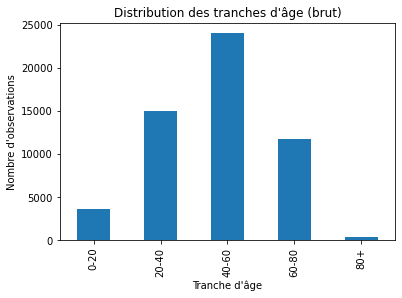

In [27]:
df["Age Group"] = pd.cut(   #creation des tranches d'age
    df["Patient Age"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0-20", "20-40", "40-60", "60-80", "80+"],
    include_lowest=True
)


df["Age Group"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution des tranches d'âge (brut)")
plt.xlabel("Tranche d'âge")
plt.ylabel("Nombre d'observations")
plt.show()

### Distribution des tranches

In [28]:
age_distribution = df["Age Group"].value_counts(normalize=True)
display(age_distribution)

Age Group
40-60    0.438134
20-40    0.274155
60-80    0.214643
0-20     0.065588
80+      0.007480
Name: proportion, dtype: float64

### Reweighting par tranche d'âge

In [29]:
df["age_weight"] = df["Age Group"].apply(lambda g: 1 / age_distribution[g])
df["age_weight"] = pd.to_numeric(df["age_weight"], errors="coerce")

In [30]:
print("Aperçu Age Group / age_weight :")
display(df[["Age Group", "age_weight"]].head(10))

Aperçu Age Group / age_weight :


,Age Group,age_weight
0,80+,133.687805
1,80+,133.687805
2,60-80,4.658904
3,60-80,4.658904
4,60-80,4.658904
5,60-80,4.658904
6,60-80,4.658904
7,60-80,4.658904
8,60-80,4.658904
9,60-80,4.658904


### Après pondération

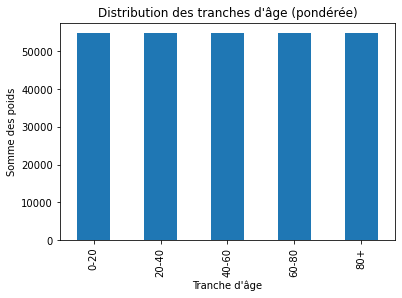

In [31]:
df.groupby("Age Group", observed=True)["age_weight"].sum().sort_index().plot(kind="bar")
plt.title("Distribution des tranches d'âge (pondérée)")
plt.xlabel("Tranche d'âge")
plt.ylabel("Somme des poids")
plt.show()

La mitigation à corriger le déséquilibre entre les tranches d’âge. En regroupant l’âge en classes et en donnent plus d’importance aux groupes rares et moins d’importance aux groupes fréquents, il est possible de réduire l’influence des groupes majoritaires et d’améliorer la représentativité des tranches d’âge sous-représentées.

## II.b Mitigation possible du biais lié aux pathologies 

### Avant pondération

In [32]:
label_counts = df["Finding Labels"].value_counts()

print("Top 10 maladies avant pondération :")
display(label_counts.head(10))

Top 10 maladies avant pondération :


Finding Labels
No Finding                  29284
Infiltration                 4684
Atelectasis                  2067
Effusion                     1970
Nodule                       1325
Mass                         1097
Pneumothorax                 1033
Effusion|Infiltration         820
Consolidation                 664
Atelectasis|Infiltration      642
Name: count, dtype: int64

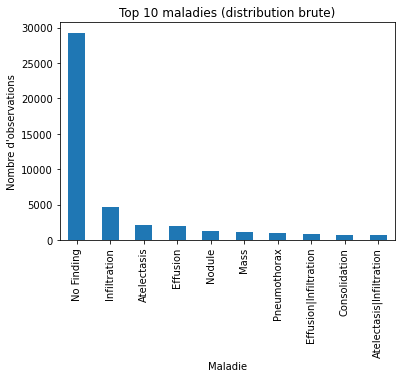

In [33]:
label_counts.head(10).plot(kind="bar")
plt.title("Top 10 maladies (distribution brute)")
plt.xlabel("Maladie")
plt.ylabel("Nombre d'observations")
plt.xticks(rotation=90)
plt.show()

### Calcul des poids

In [35]:
# distribution en proportion
label_distribution = df["Finding Labels"].value_counts(normalize=True)

#ponderation inverse
df["label_weight"] = df["Finding Labels"].apply(lambda x: 1 / label_distribution[x])

print("Aperçu des poids :")
display(df[["Finding Labels", "label_weight"]].head())

Aperçu des poids :


,Finding Labels,label_weight
0,No Finding,1.871739
1,Hernia,1054.076923
2,Hernia,1054.076923
3,Hernia,1054.076923
4,Hernia|Infiltration,9135.333333


### Distribution pondérée

In [36]:
weighted_label_counts = df.groupby("Finding Labels", observed=True)["label_weight"].sum()

print("Top 10 maladies (pondéré) :")
display(weighted_label_counts.sort_values(ascending=False).head(10))

Top 10 maladies (pondéré) :


Finding Labels
Pneumothorax|Pneumonia                                           54812.0
Cardiomegaly|Hernia|Infiltration                                 54812.0
Consolidation|Edema|Pneumothorax                                 54812.0
Consolidation|Edema|Pleural_Thickening                           54812.0
Emphysema|Infiltration|Atelectasis                               54812.0
Consolidation|Edema|Infiltration|Pleural_Thickening|Pneumonia    54812.0
Consolidation|Edema|Infiltration|Nodule                          54812.0
Consolidation|Edema|Infiltration|Mass                            54812.0
Emphysema|Infiltration|Mass                                      54812.0
Consolidation|Edema|Effusion|Pneumothorax                        54812.0
Name: label_weight, dtype: float64

### Aprés pondération

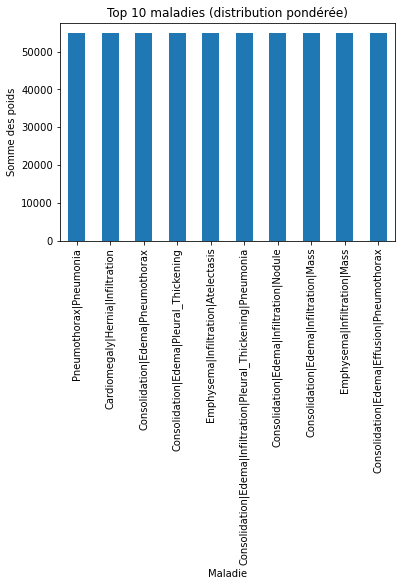

In [37]:
weighted_label_counts.sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top 10 maladies (distribution pondérée)")
plt.xlabel("Maladie")
plt.ylabel("Somme des poids")
plt.xticks(rotation=90)
plt.show()

La pondération appliquée aux labels médicaux permet de réduire le déséquilibre initial entre pathologies fréquentes et rares. Les maladies initialement sous-représentées voient leur influence statistique renforcée, tandis que les cas les plus fréquents sont atténués. Cette approche contribue à limiter le biais de représentation clinique présent dans le jeu de données.

## III. 2ème Extension possible : Mitigation du biais de genre par resampling (pré-processing)

on va faire du under-sampling

### Distribution avant

Avant :


Patient Gender
M    30812
F    24000
Name: count, dtype: int64

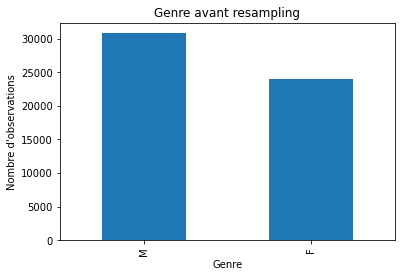

In [38]:
before_counts = df["Patient Gender"].value_counts()
print("Avant :")
display(before_counts)

before_counts.plot(kind="bar")
plt.title("Genre avant resampling")
plt.xlabel("Genre")
plt.ylabel("Nombre d'observations")
plt.show()

In [39]:
# ON SEPARE LES GROUPE

df_M = df[df["Patient Gender"] == "M"]
df_F = df[df["Patient Gender"] == "F"]

### Under-sampling : on réduit le groupe majoritaire à la taille du minoritaire

In [40]:
n = min(len(df_M), len(df_F))
df_M_under = df_M.sample(n=n, random_state=42)
df_F_under = df_F.sample(n=n, random_state=42)

df_gender_balanced = pd.concat([df_M_under, df_F_under], axis=0).sample(frac=1, random_state=42)

### Distribution après

Après under-sampling :


Patient Gender
F    24000
M    24000
Name: count, dtype: int64

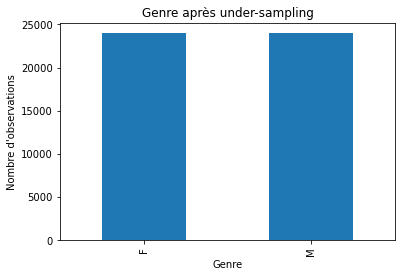

In [41]:
after_counts = df_gender_balanced["Patient Gender"].value_counts()
print("Après under-sampling :")
display(after_counts)

after_counts.plot(kind="bar")
plt.title("Genre après under-sampling")
plt.xlabel("Genre")
plt.ylabel("Nombre d'observations")
plt.show()

on a utiliser une une autre méthode de mitigation qui consiste à rééquilibrer directement le jeu de données par rééchantillonnage. Un under-sampling du groupe majoritaire (masculin) a été réalisé afin d’obtenir un nombre identique d’observations pour les patients masculins et féminins. Cette approche permet de corriger le déséquilibre initial en rendant les deux groupes comparables en taille.

mais cette méthode présente une limite importante car elle implique la suppression d’une partie des données du groupe majoritaire, ce qui peut entraîner une perte d’information.

# Conclusion 

Ce projet avait pour objectif d’analyser les biais potentiels présents dans un jeu de données médicales avant toute utilisation prédictive. L’étude s’est concentrée sur trois dimensions principales : le genre des patients, la distribution de l’âge et la représentation des pathologies.

L’analyse descriptive a mis en évidence plusieurs déséquilibres structurels. Le genre présente un déséquilibre de représentation, les patients masculins étant majoritaires. La distribution de l’âge n’est pas homogène et montre une concentration autour des tranches d’âge intermédiaires. Enfin, les labels médicaux sont fortement hétérogènes : certaines pathologies dominent largement le jeu de données tandis que de nombreuses combinaisons apparaissent très rarement.

Afin de réduire ces déséquilibres, une méthode de mitigation par pré-traitement fondée sur une pondération inversement proportionnelle à la fréquence des groupes a été appliquée. Cette approche constitue la stratégie principale retenue, car elle permet d’ajuster l’influence statistique des observations sans modifier la structure du dataset. En complément, un rééchantillonnage du groupe majoritaire a été exploré à titre illustratif afin de montrer une alternative possible, bien que cette méthode implique une perte d’information.

Ainsi, on a mis en évidence l’importance d’examiner attentivement la structure d’un jeu de données avant toute modélisation, en particulier dans un contexte médical où les biais peuvent influencer l’interprétation et l’équité des analyses.